##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFRecord 和 tf.Example

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/load_data/tfrecord" class=""><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" class="">在 TensorFlow.org 上查看 </a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/tfrecord.ipynb" class=""><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" class="">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/tfrecord.ipynb" class=""><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" class="">在  GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/load_data/tfrecord.ipynb" class=""><img src="https://tensorflow.google.cn/images/download_logo_32px.png" class="">下载笔记本</a></td>
</table>

为了高效地读取数据，比较有帮助的一种做法是对数据进行序列化并将其存储在一组可线性读取的文件（每个文件 100-200MB）中。这尤其适用于通过网络进行流式传输的数据。这种做法对缓冲任何数据预处理也十分有用。

TFRecord 格式是一种用于存储二进制记录序列的简单格式。

[协议缓冲区](https://developers.google.com/protocol-buffers/)是一个跨平台、跨语言的库，用于高效地序列化结构化数据。

协议消息由 `.proto` 文件定义，这通常是了解消息类型最简单的方法。

`tf.Example` 消息（或 protobuf）是一种灵活的消息类型，表示 `{"string": value}` 映射。它专为 TensorFlow 而设计，并被用于 [TFX](https://tensorflow.google.cn/tfx/) 等高级 API。

本笔记本将演示如何创建、解析和使用 `tf.Example` 消息，以及如何在 `.tfrecord` 文件之间对 `tf.Example` 消息进行序列化、写入和读取。

注：这些结构虽然有用，但并不是强制的。您无需转换现有代码即可使用 TFRecord，除非您正在使用 [tf.data](https://tensorflow.google.cn/guide/datasets) 且读取数据仍是训练的瓶颈。有关数据集性能的提示，请参阅[数据输入流水线性能](https://tensorflow.google.cn/guide/performance/datasets)。

## 设置

In [2]:
import tensorflow as tf

import numpy as np
import IPython.display as display

## `tf.Example`

### `tf.Example` 的数据类型

从根本上讲，`tf.Example` 是 `{"string": tf.train.Feature}` 映射。

`tf.train.Feature` 消息类型可以接受以下三种类型（请参阅 [`.proto` 文件](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto)）。大多数其他通用类型也可以强制转换成下面的其中一种：

1. `tf.train.BytesList`（可强制转换自以下类型）

- `string`
- `byte`

1. `tf.train.FloatList`（可强制转换自以下类型）

- `float` (`float32`)
- `double` (`float64`)

1. `tf.train.Int64List`（可强制转换自以下类型）

- `bool`
- `enum`
- `int32`
- `uint32`
- `int64`
- `uint64`

为了将标准 TensorFlow 类型转换为兼容 `tf.Example` 的 `tf.train.Feature`，可以使用下面的快捷函数。请注意，每个函数会接受标量输入值并返回包含上述三种 `list` 类型之一的 `tf.train.Feature`：

In [3]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

注：为了简单起见，本示例仅使用标量输入。要处理非标量特征，最简单的方法是使用 `tf.io.serialize_tensor` 将张量转换为二进制字符串。在 TensorFlow 中，字符串是标量。使用 `tf.io.parse_tensor` 可将二进制字符串转换回张量。

下面是有关这些函数如何工作的一些示例。请注意不同的输入类型和标准化的输出类型。如果函数的输入类型与上述可强制转换的类型均不匹配，则该函数将引发异常（例如，`_int64_feature(1.0)` 将出错，因为 `1.0` 是浮点数，应该用于 `_float_feature` 函数）：

In [4]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



可以使用 `.SerializeToString` 方法将所有协议消息序列化为二进制字符串：

In [5]:
feature = _float_feature(np.exp(1))

feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

### 创建 `tf.Example` 消息

假设您要根据现有数据创建 `tf.Example` 消息。在实践中，数据集可能来自任何地方，但是从单个观测值创建 `tf.Example` 消息的过程相同：

1. 在每个观测结果中，需要使用上述其中一种函数，将每个值转换为包含三种兼容类型之一的 `tf.train.Feature`。

2. 创建一个从特征名称字符串到第 1 步中生成的编码特征值的映射（字典）。

3. 将第 2 步中生成的映射转换为 [`Features` 消息](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto#L85)。

在此笔记本中，您将使用 NumPy 创建一个数据集。

此数据集将具有 4 个特征：

- 具有相等 `False` 或 `True` 概率的布尔特征
- 从 `[0, 5]` 均匀随机选择的整数特征
- 通过将整数特征作为索引从字符串表生成的字符串特征
- 来自标准正态分布的浮点特征

请思考一个样本，其中包含来自上述每个分布的 10,000 个独立且分布相同的观测值：

In [6]:
# The number of observations in the dataset.
n_observations = int(1e4)

# Boolean feature, encoded as False or True.
feature0 = np.random.choice([False, True], n_observations)

# Integer feature, random from 0 to 4.
feature1 = np.random.randint(0, 5, n_observations)

# String feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature, from a standard normal distribution
feature3 = np.random.randn(n_observations)

您可以使用 `_bytes_feature`、`_float_feature` 或 `_int64_feature` 将下面的每个特征强制转换为兼容 `tf.Example` 的类型。然后，可以通过下面的已编码特征创建 `tf.Example` 消息：

In [7]:
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.Example-compatible
  # data type.
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

例如，假设您从数据集中获得了一个观测值 `[False, 4, bytes('goat'), 0.9876]`。您可以使用 `create_message()` 创建和打印此观测值的 `tf.Example` 消息。如上所述，每个观测值将被写为一条 `Features` 消息。请注意，`tf.Example` [消息](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/example.proto#L88)只是 `Features` 消息外围的包装器：

In [8]:
# This is an example observation from the dataset.

example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04'

要解码消息，请使用 `tf.train.Example.FromString` 方法。

In [9]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

## TFRecords 格式详细信息

TFRecord 文件包含一系列记录。该文件只能按顺序读取。

每条记录包含一个字节字符串（用于数据有效负载），外加数据长度，以及用于完整性检查的 CRC32C（使用 Castagnoli 多项式的 32 位 CRC）哈希值。

每条记录会存储为以下格式：

```
uint64 length uint32 masked_crc32_of_length byte   data[length] uint32 masked_crc32_of_data
```

将记录连接起来以生成文件。[此处](https://en.wikipedia.org/wiki/Cyclic_redundancy_check)对 CRC 进行了说明，且 CRC 的掩码为：

```
masked_crc = ((crc >> 15) | (crc << 17)) + 0xa282ead8ul
```

注：不需要在 TFRecord 文件中使用 `tf.Example`。`tf.Example` 只是将字典序列化为字节字符串的一种方法。文本行、编码的图像数据，或序列化的张量（使用 `tf.io.serialize_tensor`，或在加载时使用 `tf.io.parse_tensor`）。有关更多选项，请参阅 `tf.io` 模块。

## 使用 `tf.data` 的 TFRecord 文件

`tf.data` 模块还提供用于在 TensorFlow 中读取和写入数据的工具。

### 写入 TFRecord 文件

要将数据放入数据集中，最简单的方式是使用 `from_tensor_slices` 方法。

若应用于数组，将返回标量数据集：

In [10]:
tf.data.Dataset.from_tensor_slices(feature1)

<TensorSliceDataset shapes: (), types: tf.int64>

若应用于数组的元组，将返回元组的数据集：

In [11]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
features_dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.bool, tf.int64, tf.string, tf.float64)>

In [12]:
# Use `take(1)` to only pull one example from the dataset.
for f0,f1,f2,f3 in features_dataset.take(1):
  print(f0)
  print(f1)
  print(f2)
  print(f3)

tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'dog', shape=(), dtype=string)
tf.Tensor(-0.07658295354196158, shape=(), dtype=float64)


使用 `tf.data.Dataset.map` 方法可将函数应用于 `Dataset` 的每个元素。

映射函数必须在 TensorFlow 计算图模式下进行运算（它必须在 `tf.Tensors` 上运算并返回）。可以使用 `tf.py_function` 包装非张量函数（如 `serialize_example`）以使其兼容。

使用 `tf.py_function` 需要指定形状和类型信息，否则它将不可用：

In [13]:
def tf_serialize_example(f0,f1,f2,f3):
  tf_string = tf.py_function(
    serialize_example,
    (f0,f1,f2,f3),  # pass these args to the above function.
    tf.string)      # the return type is `tf.string`.
  return tf.reshape(tf_string, ()) # The result is a scalar

In [14]:
tf_serialize_example(f0,f1,f2,f3)

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x86\xd7\x9c\xbd\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00'>

将此函数应用于数据集中的每个元素：

In [15]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

<MapDataset shapes: (), types: tf.string>

In [16]:
def generator():
  for features in features_dataset:
    yield serialize_example(*features)

In [17]:
serialized_features_dataset = tf.data.Dataset.from_generator(
    generator, output_types=tf.string, output_shapes=())

In [18]:
serialized_features_dataset

<FlatMapDataset shapes: (), types: tf.string>

并将它们写入 TFRecord 文件：

In [19]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

### 读取 TFRecord 文件

您还可以使用 `tf.data.TFRecordDataset` 类来读取 TFRecord 文件。

有关通过 `tf.data` 使用 TFRecord 文件的详细信息，请参见[此处](https://tensorflow.google.cn/guide/datasets#consuming_tfrecord_data)。

使用 `TFRecordDataset` 对于标准化输入数据和优化性能十分有用。

In [20]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

此时，数据集包含序列化的 `tf.train.Example` 消息。迭代时，它会将其作为标量字符串张量返回。

使用 `.take` 方法仅显示前 10 条记录。

注：在 `tf.data.Dataset` 上进行迭代仅在启用了 Eager Execution 时有效。

In [21]:
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x86\xd7\x9c\xbd\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xa2\x97\xeb=\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04!a]?\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xc4\x84`\xbf\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\n

可以使用以下函数对这些张量进行解析。请注意，这里的 `feature_description` 是必需的，因为数据集使用计算图执行，并且需要以下描述来构建它们的形状和类型签名：

In [22]:
# Create a description of the features.
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

或者，使用 `tf.parse example` 一次解析整个批次。使用 `tf.data.Dataset.map` 方法将此函数应用于数据集中的每一项：

In [23]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset shapes: {feature0: (), feature1: (), feature2: (), feature3: ()}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

使用 Eager Execution 在数据集中显示观测值。此数据集中有 10,000 个观测值，但只会显示前 10 个。数据会作为特征字典进行显示。每一项都是一个 `tf.Tensor`，此张量的 `numpy` 元素会显示特征的值：

In [24]:
for parsed_record in parsed_dataset.take(10):
  print(repr(parsed_record))

{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.07658295>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.11503531>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'cat'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.8647633>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.87702584>}
{'feature0': <t

在这里，`tf.parse_example` 函数会将 `tf.Example` 字段解压缩为标准张量。

## Python 中的 TFRecord 文件

`tf.io` 模块还包含用于读取和写入 TFRecord 文件的纯 Python 函数。

### 写入 TFRecord 文件

接下来，将 10,000 个观测值写入文件 `test.tfrecord`。每个观测值都将转换为一条 `tf.Example` 消息，然后被写入文件。随后，您可以验证是否已创建 `test.tfrecord` 文件：

In [25]:
# Write the `tf.Example` observations to the file.
with tf.io.TFRecordWriter(filename) as writer:
  for i in range(n_observations):
    example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
    writer.write(example)

In [26]:
!du -sh {filename}

984K	test.tfrecord


### 读取 TFRecord 文件

您可以使用 `tf.train.Example.ParseFromString` 轻松解析以下序列化张量：

In [27]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [28]:
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "dog"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -0.07658295333385468
      }
    }
  }
}



## 演练：读取和写入图像数据

下面是关于如何使用 TFRecord 读取和写入图像数据的端到端示例。您将使用图像作为输入数据，将数据写入 TFRecord 文件，然后将文件读取回来并显示图像。

如果您想在同一个输入数据集上使用多个模型，这种做法会很有用。您可以不以原始格式存储图像，而是将图像预处理为 TFRecord 格式，然后将其用于所有后续的处理和建模中。

首先，让我们下载雪中的猫的[图像](https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg)，以及施工中的纽约威廉斯堡大桥的[照片](https://upload.wikimedia.org/wikipedia/commons/f/fe/New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg)。

### 提取图像

In [29]:
cat_in_snow  = tf.keras.utils.get_file('320px-Felis_catus-cat_on_snow.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')
williamsburg_bridge = tf.keras.utils.get_file('194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

 8192/17858 [============>.................] - ETA: 0s

24576/17858 [=========================================] - 0s 0us/step


 8192/15477 [==============>...............] - ETA: 0s

16384/15477 [===============================] - 0s 0us/step


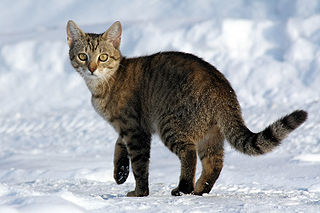

In [30]:
display.display(display.Image(filename=cat_in_snow))
display.display(display.HTML('Image cc-by: &lt;a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg"&gt;Von.grzanka&lt;/a&gt;'))

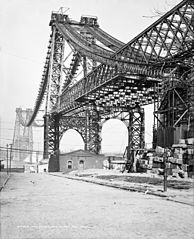

In [31]:
display.display(display.Image(filename=williamsburg_bridge))
display.display(display.HTML('&lt;a "href=https://commons.wikimedia.org/wiki/File:New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg"&gt;From Wikimedia&lt;/a&gt;'))

### 写入 TFRecord 文件

和以前一样，将特征编码为与 `tf.Example` 兼容的类型。这将存储原始图像字符串特征，以及高度、宽度、深度和任意 `label` 特征。后者会在您写入文件以区分猫和桥的图像时使用。将 `0` 用于猫的图像，将 `1` 用于桥的图像：

In [32]:
image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}

In [33]:
# This is an example, just using the cat image.
image_string = open(cat_in_snow, 'rb').read()

label = image_labels[cat_in_snow]

# Create a dictionary with features that may be relevant.
def image_example(image_string, label):
  image_shape = tf.image.decode_jpeg(image_string).shape

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

for line in str(image_example(image_string, label)).split('\n')[:15]:
  print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 213
      }
...


请注意，所有特征现在都存储在 `tf.Example` 消息中。接下来，函数化上面的代码，并将示例消息写入名为 `images.tfrecords` 的文件：

In [34]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in image_labels.items():
    image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [35]:
!du -sh {record_file}

36K	images.tfrecords


### 读取 TFRecord 文件

现在，您有文件 `images.tfrecords`，并可以迭代其中的记录以将您写入的内容读取回来。因为在此示例中您只需重新生成图像，所以您只需要原始图像字符串这一个特征。使用上面描述的 getter 方法（即 `example.features.feature['image_raw'].bytes_list.value[0]`）提取该特征。您还可以使用标签来确定哪个记录是猫，哪个记录是桥：

In [36]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

从 TFRecord 文件中恢复图像：

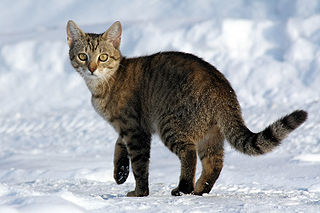

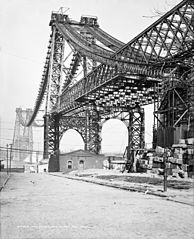

In [37]:
for image_features in parsed_image_dataset:
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))